## Exploratory Data Analysis

In [2]:
import pandas as pd
import numpy as np
import nfl_data_py as nfl
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns

seasons = range(2016, 2024+1)
pbp_py = nfl.import_pbp_data(seasons)

pbp_py_run =\
    pbp_py\
    .query('play_type == "run" & rusher_id.notnull() &' +
               'down.notnull() & run_location.notnull()')\
                .reset_index()

pbp_py_run\
    .loc[pbp_py_run.rushing_yards.isnull(), 'rushing_yards'] = 0

2016 done.
2017 done.
2018 done.
2019 done.
2020 done.
2021 done.
2022 done.
2023 done.
2024 done.
Downcasting floats.


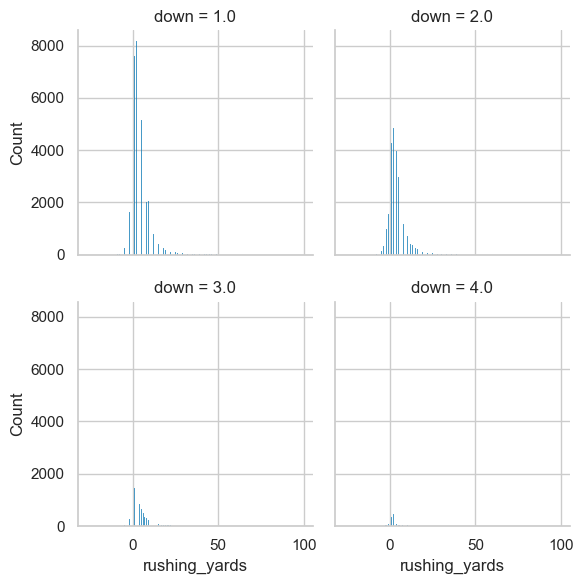

In [3]:
## Histogram to look at down and rushing yards gained
sns.set_theme(style = 'whitegrid', palette = 'colorblind')

# change down to be a string: python defaults to treat down as continuous instead of discrete
pbp_py_run.down =\
    pbp_py_run.down.astype(str)

# Define the order to show the individual grids. They may not be in order by default because we converted down to string
down_order = ['1.0', '2.0', '3.0', '4.0']

g = \
    sns.FacetGrid( data = pbp_py_run, 
                      col = 'down', col_wrap = 2, col_order = down_order);
g.map_dataframe(sns.histplot, x = 'rushing_yards')
plt.show()

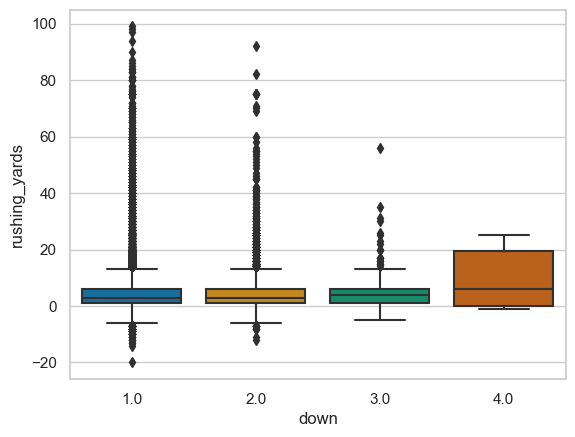

In [5]:
## Yards seem to decrease as down increases. What if we try to control for yardage?
sns.boxplot(data = pbp_py_run.query('ydstogo == 10'),
               x = 'down',
               y = 'rushing_yards')
plt.show()

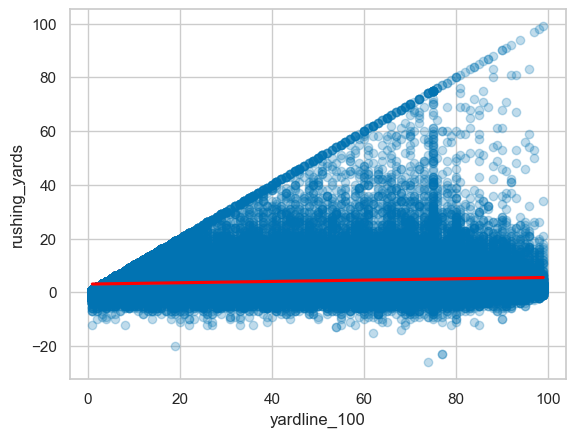

In [7]:
## What if we look at yards to the endzone and how it affects rushing yards?
sns.regplot(
    data = pbp_py_run,
    x = 'yardline_100',
    y = 'rushing_yards',
    scatter_kws= {'alpha': 0.25}, #changes transparency of plots
    line_kws= {'color': 'red'}) #changes reression line color
plt.show()

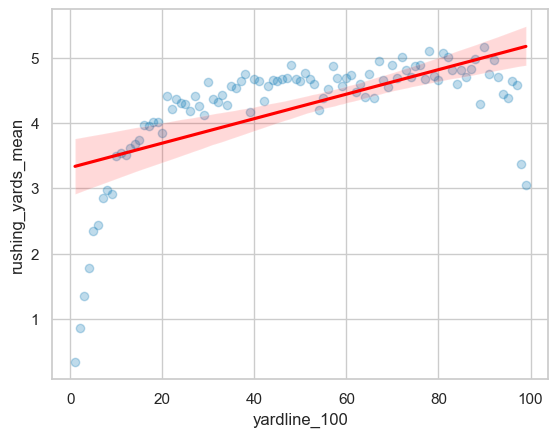

In [13]:
## what if we see what happens when we bin and averae rushings yards?

pbp_py_run_y100 =\
    pbp_py_run\
    .groupby('yardline_100')\
    .agg({'rushing_yards': ['mean']})

pbp_py_run_y100.columns =\
    list(map('_'.join, pbp_py_run_y100.columns))

pbp_py_run_y100.reset_index(inplace = True)

sns.regplot(
    data = pbp_py_run_y100,
    x = 'yardline_100',
    y = 'rushing_yards_mean',
    scatter_kws = {'alpha': 0.25},
    line_kws = {'color': 'red'})

plt.show()

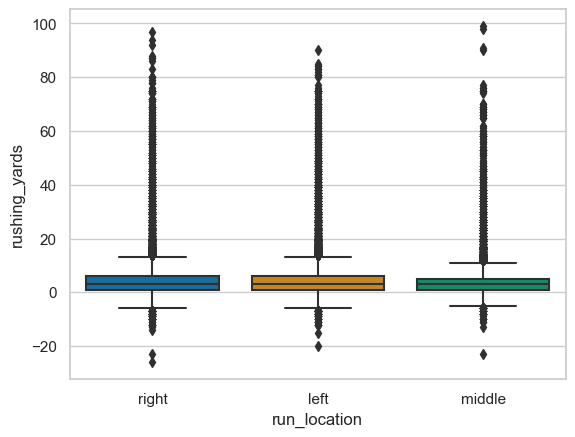

In [14]:
## Is there any insight we can gain by looking at run location?

sns.boxplot(data = pbp_py_run,
               x = 'run_location',
               y = 'rushing_yards')

plt.show()

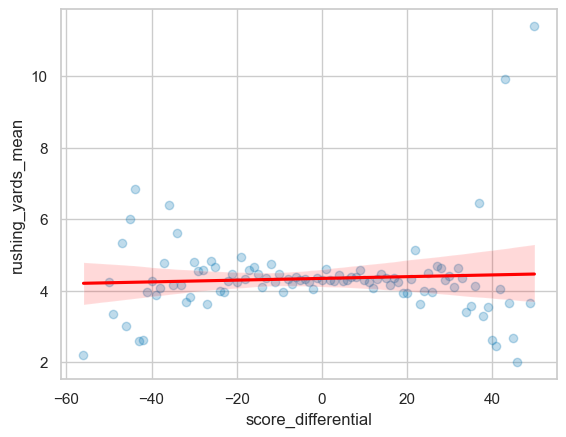

In [67]:
## What about score differential?

pbp_py_run_sd =\
    pbp_py_run\
    .groupby('score_differential')\
    .agg({'rushing_yards': ['mean']})

pbp_py_run_sd.columns =\
    list(map('_'.join, pbp_py_run_sd.columns))

pbp_py_run_sd.reset_index(inplace = True)

sns.regplot(
    data = pbp_py_run_sd, 
    x = 'score_differential',
    y = 'rushing_yards_mean',
    scatter_kws = {'alpha': 0.25},
    line_kws = {'color': 'red'})

plt.show()

## Applying Multiple Linear Regression

This model predicts rushing_yards by creating the following:
- an intercept
- a term contrasting the second, third, and fourth downs to the first down (down)
- a coefficient for ydstogo
- an interaction between ydstogo and down that estimates ydstogo contrast for each down (ydstogo:down)
- a coefficient for yards to go to the endzone (yardline_100)
- the location of the running play on the field (run_location)
- the difference between each teams scores (score_differential)

In [34]:
## Fit the model and save the residuals as RYOE

pbp_py_run.down =\
    pbp_py.down.astype(str)

expected_yards_py =\
    smf.ols(
        data = pbp_py_run,
        formula = "rushing_yards ~ 1 + down + ydstogo + " +
        "down:ydstogo + yardline_100 + " +
        "run_location + score_differential")\
        .fit()

pbp_py_run['ryoe'] =\
    expected_yards_py.resid

print(expected_yards_py.summary())

                            OLS Regression Results                            
Dep. Variable:          rushing_yards   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     130.5
Date:                Thu, 26 Dec 2024   Prob (F-statistic):          4.36e-299
Time:                        12:51:59   Log-Likelihood:            -3.1535e+05
No. Observations:               97077   AIC:                         6.307e+05
Df Residuals:                   97065   BIC:                         6.308e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  2

## Analyzing RYOE

In [178]:
## Create summary tables, save data for players with over 50 rushes, and clean up columns

ryoe_py =\
    pbp_py_run\
    .groupby(['season', 'rusher', 'rusher_id'])\
    .agg({'ryoe': ['count', 'sum', 'mean'],
       'rushing_yards': ['mean']})

ryoe_py.columns =\
    list(map('_'.join, ryoe_py.columns))
ryoe_py.reset_index(inplace = True)
    
ryoe_py =\
    ryoe_py.rename(columns = {
        'ryoe_count': 'n',
        'ryoe_sum': 'ryoe_total',
        'ryoe_mean': 'ryoe_per',
        'rushing_yards_mean': 'yards_per_carry'
    })\
    .query('n > 50 & season == 2024')

pd.set_option('display.max_rows', 10)

print(ryoe_py.sort_values('ryoe_total', ascending = False))

      season     rusher   rusher_id    n  ryoe_total  ryoe_per  \
2855    2024  S.Barkley  00-0034844  221  412.981637  1.868695   
2756    2024    J.Gibbs  00-0039139  144  225.161390  1.563621   
2701    2024    D.Henry  00-0032764  200  143.658083  0.718290   
2768    2024    J.Mason  00-0037525  131  137.412940  1.048954   
2644    2024    A.Jones  00-0033293  166   91.584483  0.551714   
...      ...        ...         ...  ...         ...       ...   
2910    2024     Z.Moss  00-0036251   65  -84.020941 -1.292630   
2911    2024    Z.White  00-0038040   59  -88.093289 -1.493107   
2716    2024    D.Swift  00-0036275  161 -103.777040 -0.644578   
2837    2024   N.Harris  00-0036893  172 -106.688379 -0.620281   
2800    2024     K.Hunt  00-0033923  145 -106.941697 -0.737529   

      yards_per_carry  
2855         6.101504  
2756         5.707865  
2701         5.862500  
2768         5.156863  
2644         4.532995  
...               ...  
2910         3.270270  
2911         2.